#1. 모듈 선언

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms # Data Augmentation

import pdb # 파이토치에서 디버깅하는 라이브러리이다. 사용 법은 Train model가면 볼수 있음.

#2. device 전환

In [2]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda:0 이렇게 쓰면 GPU1개 쓴다는 의미이다. cuda 이렇게 쓰면 전부 쓴다는 것이다.
device

device(type='cuda')

#3. Hyper Parameters 설정

In [3]:
# Hyper Parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001 # 값이 너무 작으면 학습 속도가 오래걸리고, 값이 너무 크면 발산한다.

#4. Load Datas

In [4]:
'''
ToTensor()의 3가지 기능
1. 이미지를 255로 나눠서 스케일링을 진행한다.
2. Tensor 타입으로 형 변환 시켜줌
3. 32x32x3 인데 채널을 앞으로 보내준다. 3x32x32이 처럼...
'''
# Data Loader : step 1
train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform = transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=False,
                                           transform = transforms.ToTensor(),
                                           )
# Data Loader : step 2
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

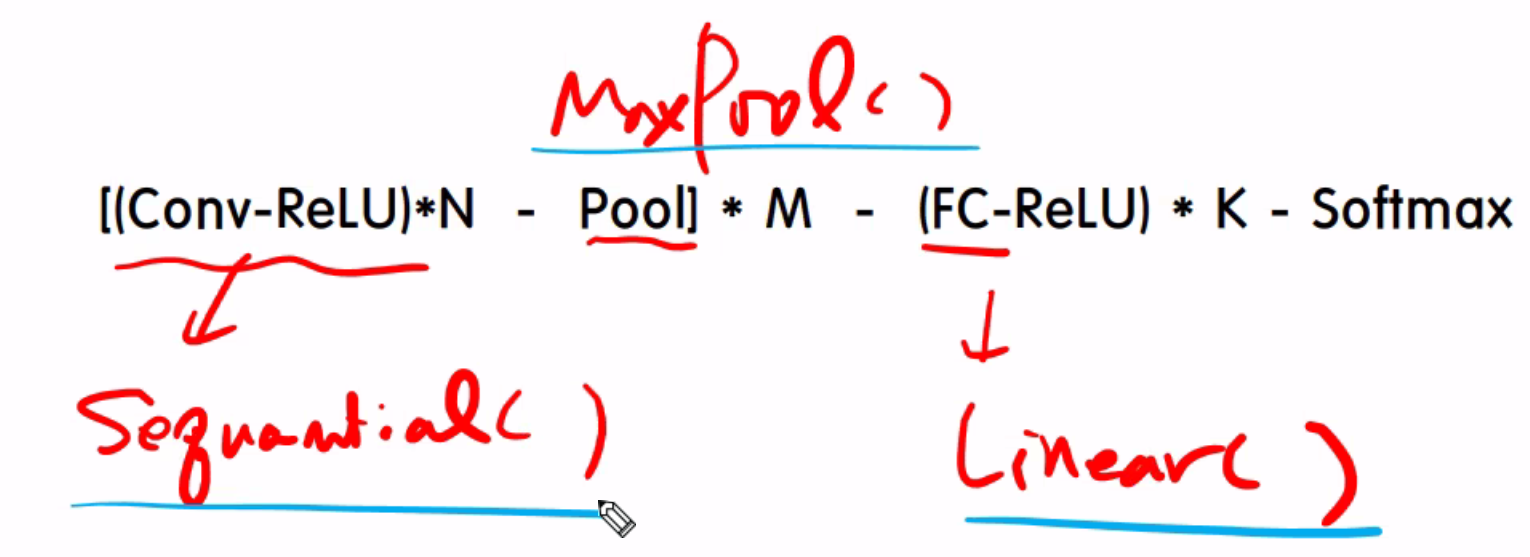

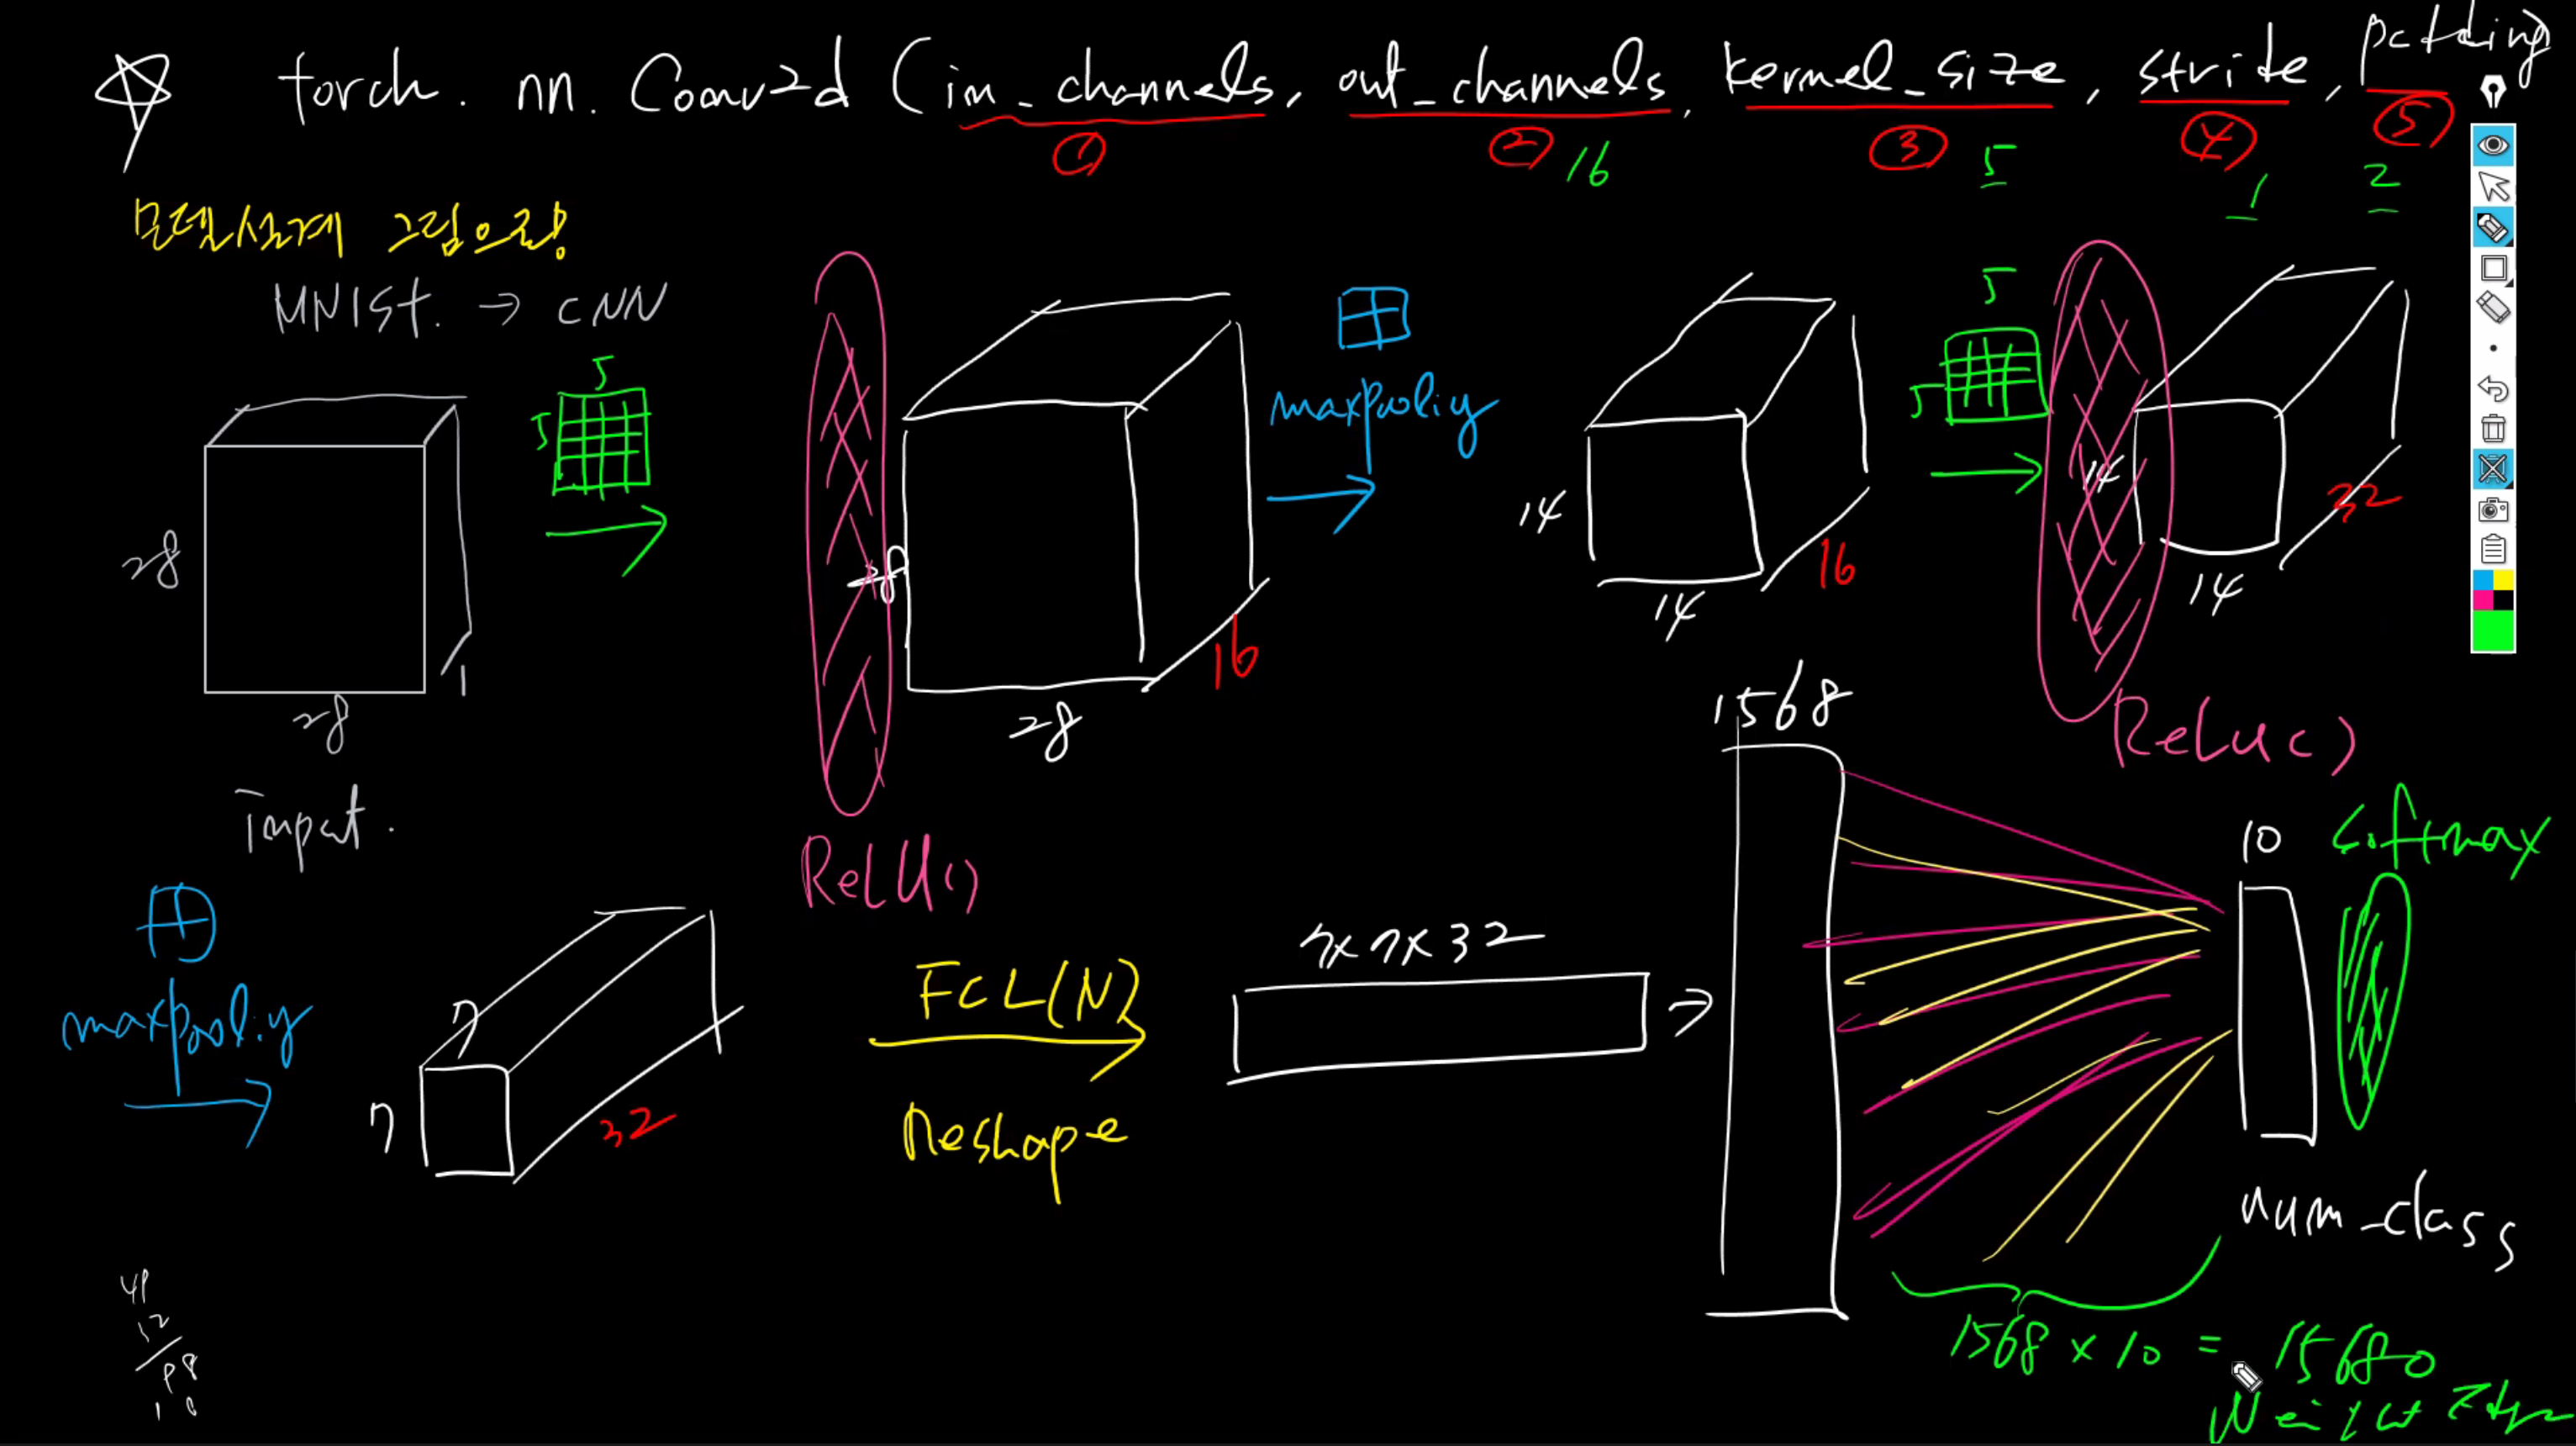

점점 작아지는 것 : 이미지 사이즈  
점점 늘어나는 것 : feature map의 채널수 즉, 특징들을 뽑아낸다는 뜻이다.

#5. Make NN Class

In [5]:
# Convolution NeuralNet ... two convolutional Layers
class ConvNet(nn.Module): # nn.Module을 상속 받아야 한다.
  def __init__(self, num_classes=10):
    super(ConvNet,self).__init__()
    self.layer1 = nn.Sequential( # Convolution Layer 연산하는 함수이다.
        nn.Conv2d(1,16,kernel_size=5,stride=1,padding=2), # input채널수(흑백이라서 1이다. 컬러는 3) , output채널수, 커널사이즈 5x5
        # output채널수 = feature map의 채널 갯수
        # nn.Linear(input_size, hidden_size),

        # nn.BatchNomal2d(100) >> 이것으로 학습이 잘 되도록 값들을 차분하게 만들어준다.
        nn.ReLU()
    )
    self.layer2 = nn.MaxPool2d(kernel_size=2,stride=2)
    self.layer3 = nn.Sequential( # Convolution Layer 연산하는 함수이다.
        nn.Conv2d(16,32,kernel_size=5,stride=1,padding=2), # input채널수 , output채널수, 커널사이즈 5x5
        # output채널수 = feature map의 채널 갯수
        # nn.Linear(input_size, hidden_size),
        
        # nn.BatchNomal2d(100) >> 이것으로 학습이 잘 되도록 값들을 차분하게 만들어준다.
        nn.ReLU()
    )
    self.layer4 = nn.MaxPool2d(kernel_size=2,stride=2)
    self.layer5 = nn.Linear(7*7*32, num_classes) # 마지막엔 FCN으로 모듈의 예측값을 얻어야한다.
    

  def forward(self, x): # 모델에서 채널이 어떻게 변하는지 알고 싶으면 이곳에 pdb를사용해서 디버깅해봐야 한다.
    # 2. pdb
    #pdb.set_trace()
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = out.reshape(out.size(0), -1) # batchsize, (가로x세로)  FCN 이므로 reshape으로 한줄로 펼처서 넣어줘야 한다.
    out = self.layer5(out) 
    return out

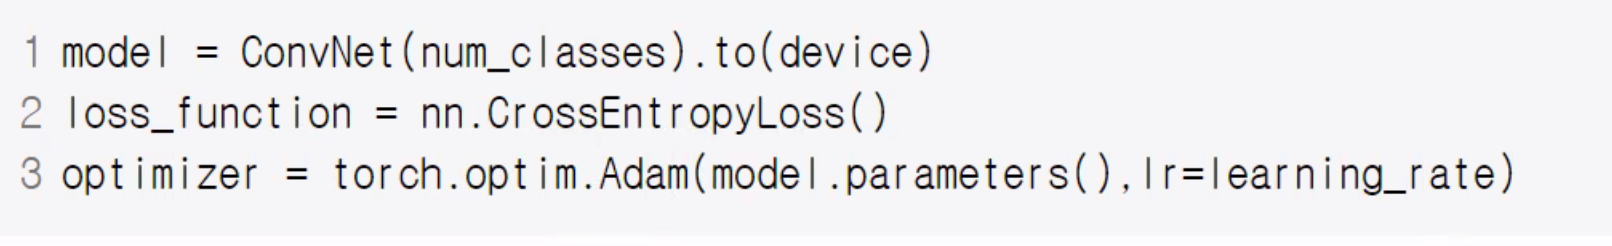

#6. Generate model, loss_fuinction, optimizer

In [6]:
model = ConvNet(num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

#7. Learn Model

In [7]:
total_step = len(train_loader) # batch_size를 100으로 해서 600이 나옴.
loss_list = []
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader): # 이미지랑 라벨을 100개씩 가져온다.
    images = images.to(device)
    labels = labels.to(device)

    # 1. pdb사용해서 디버깅 해보기 > image 사이즈와 label을 알 수 있다.
    # pdb.set_trace() # 함수가 실행될때 멈춘다. Pdb박스가 나오는데 'l'을 누르면 어디 실행 할지를 알려준다. // 사용하고 q로 멈추고 주석으로 막아 논다.

    outputs = model(images) # model(images) 동일한 표현이 model.forward(images), 2. pdb 여기서 디버깅이 실행된다. 'l'list 호출해서 확인할 수 있다. 'n' next를 의미하며 다음으로 넘어간다.
    
    # 3. pdb사용 모델이 예측값을 뱉은 다음도 살펴봄
    # pdb.set_trace() # loss.item()  = batch_size 100개 한 값이 나온다. (100,10)가 나오는걸 확인해보자.

    loss = loss_function(outputs, labels)

    optimizer.zero_grad() # 초기화 진행

    loss.backward() # w, b를 바꿔주기 위해 loss_function을 backward 시킨다.
    optimizer.step()
    loss_list.append(loss.item())
    if(i+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step[{i+1}/{total_step}], Loss:{loss.item():.4f}')

Epoch [1/5], Step[100/600], Loss:0.2145
Epoch [1/5], Step[200/600], Loss:0.0779
Epoch [1/5], Step[300/600], Loss:0.1050
Epoch [1/5], Step[400/600], Loss:0.0509
Epoch [1/5], Step[500/600], Loss:0.0584
Epoch [1/5], Step[600/600], Loss:0.1003
Epoch [2/5], Step[100/600], Loss:0.0484
Epoch [2/5], Step[200/600], Loss:0.0873
Epoch [2/5], Step[300/600], Loss:0.0522
Epoch [2/5], Step[400/600], Loss:0.0623
Epoch [2/5], Step[500/600], Loss:0.0582
Epoch [2/5], Step[600/600], Loss:0.0105
Epoch [3/5], Step[100/600], Loss:0.0379
Epoch [3/5], Step[200/600], Loss:0.0251
Epoch [3/5], Step[300/600], Loss:0.0380
Epoch [3/5], Step[400/600], Loss:0.0498
Epoch [3/5], Step[500/600], Loss:0.1221
Epoch [3/5], Step[600/600], Loss:0.0099
Epoch [4/5], Step[100/600], Loss:0.0383
Epoch [4/5], Step[200/600], Loss:0.0114
Epoch [4/5], Step[300/600], Loss:0.0153
Epoch [4/5], Step[400/600], Loss:0.0486
Epoch [4/5], Step[500/600], Loss:0.0181
Epoch [4/5], Step[600/600], Loss:0.0074
Epoch [5/5], Step[100/600], Loss:0.0312


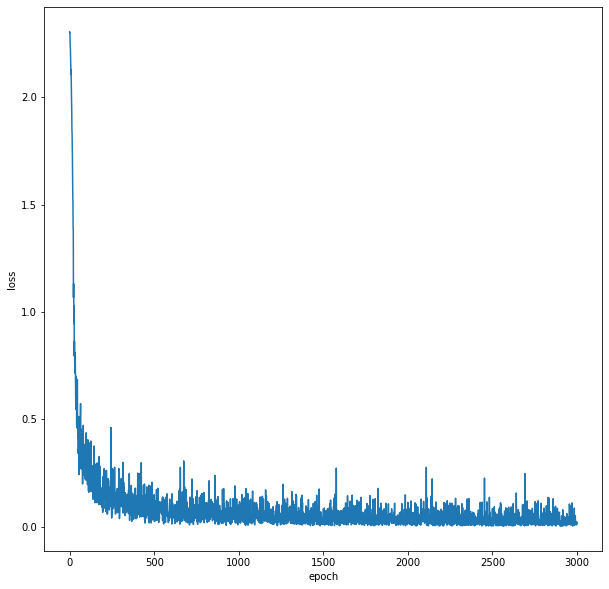

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Evaluation(Test) Model 평가모델

  모델은 크게 2가지 모델이 있다.
  1. Train Model
  2. Evaluation Model

  Evaluation Model은 학습을 안해도 되기 때문에 빠른 속도로 돌릴 필요가 있다.
  eval()을 사용 한다.

  학습진행을 안하겠다는 뜻은 2가지 단계로 풀이 된다.  
  1) 모델에게 evaluation 모드지정  
  2) Gradient 에게도 계산 하지 시키지 않는다  

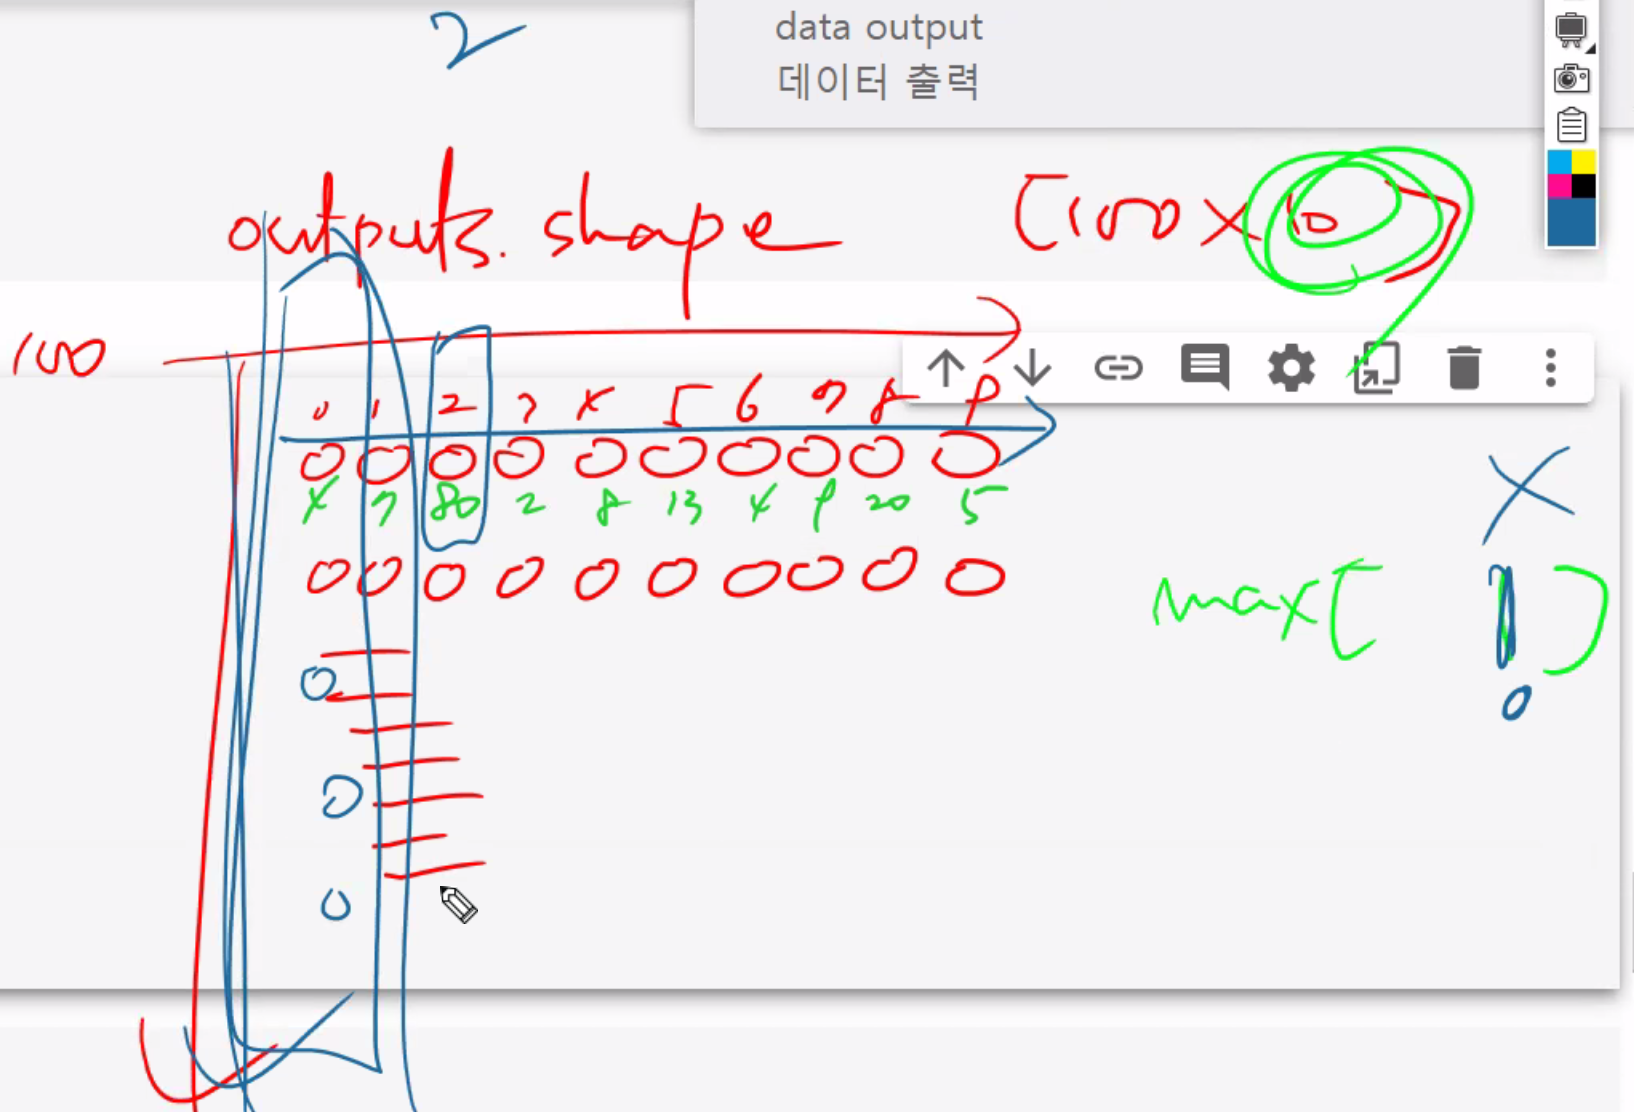

#8. Make Evaluation Model (평가 모델)

In [9]:
model.eval() # 평가모델이라고 선언을 하는 것이다.
with torch.no_grad(): # 메모리를 미리 할당하지 않아서 속도가 매우 빨라진다.
  correct = 0 # 맞춘 문제의 갯수
  total = 0 # 전체 문제 갯수
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images) # images.shape은 (100x1x28x28)으로 4차원이 된다. outputs은 (100x10) 나온다. /// model()은 model.forward()와 같은 형태의 함수이다.
    # 4. pdb 사용 outputs.shape >> 사이즈 나옴, outputs[1], 두번째 사진이 뭔지 예측한 값이나옴., predicted예측한 값들 100개가 리스트로 나온다.
    # pdb.set_trace()

    _, predicted = torch.max(outputs.data,1) # 평가모델이라서 가장 큰 값을 바로 뽑아내면 된다. torch.max(outputs.data,1)에서 value,index가 리턴된다.

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy {round(correct/total*100,3)}%')

Accuracy 98.98%


#9. save a model data

In [10]:
torch.save(model.state_dict, 'model.ckpt')

In [11]:
images.size()

torch.Size([100, 1, 28, 28])

In [12]:
images[0].size()

torch.Size([1, 28, 28])

In [13]:
images[0][0].size() # 이미지의 사이즈

torch.Size([28, 28])

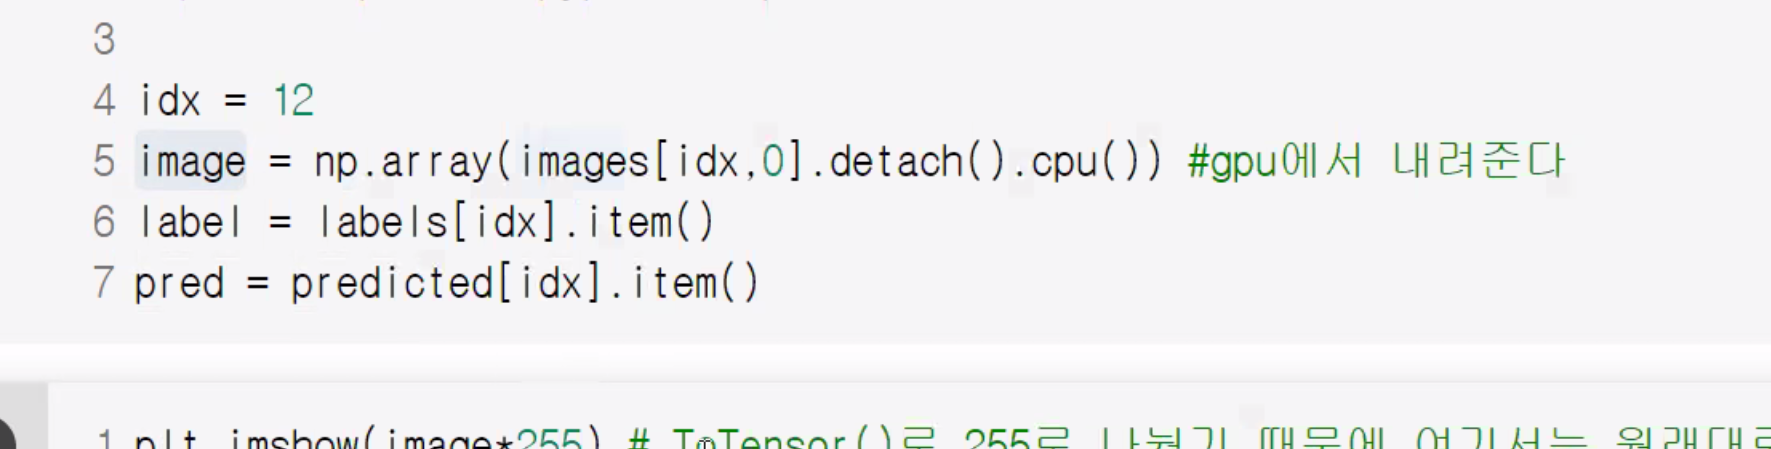

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
idx = 12 # 12번째 이미지를 한번 봐보자
image = np.array(images[idx,0].detach().cpu()) # 이미지를 보기위해선 numpy로 바꿔주고 CPU연산해줘야한다.

label = labels[idx].item()
pred = predicted[idx].item()

#plt.imshow(image*255) # ToTensor()로 255로 나눴기 때분에 다시 돌려줘야 이미지를 볼 수 있다.

Lable tensor([8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6, 4, 1,
        9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3, 3, 9, 1, 4,
        0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3, 6, 8, 7, 1, 5, 2,
        4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
        3, 4, 5, 6], device='cuda:0')
pred tensor([8, 9, 0, 1, 8, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6, 4, 1,
        9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3, 3, 9, 1, 4,
        0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3, 6, 8, 7, 1, 5, 2,
        4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
        3, 4, 5, 6], device='cuda:0')


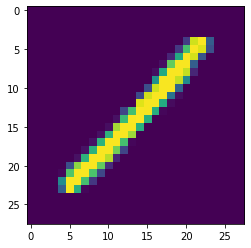

In [16]:
plt.imshow(image*255) # ToTensor()로 255로 나눴기 때분에 다시 돌려줘야 이미지를 볼 수 있다.
print('Lable',labels)
print('pred',predicted)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


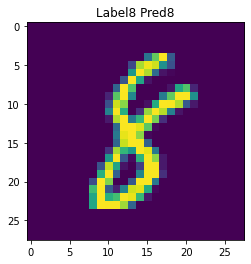

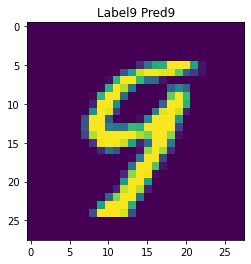

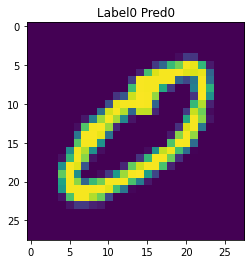

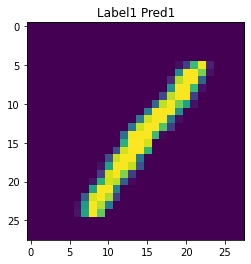

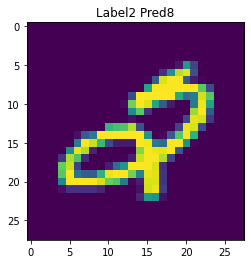

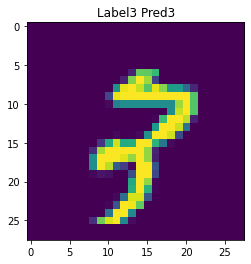

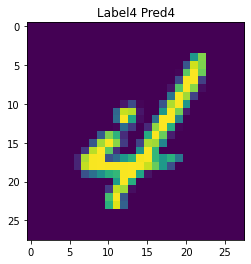

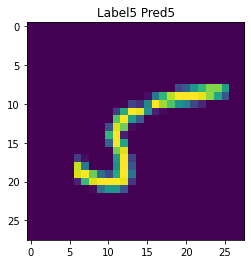

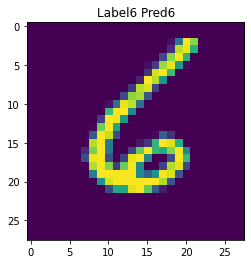

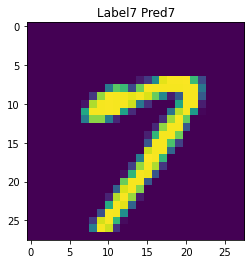

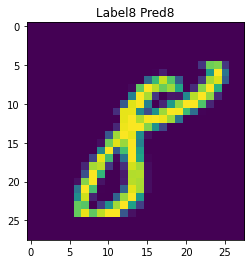

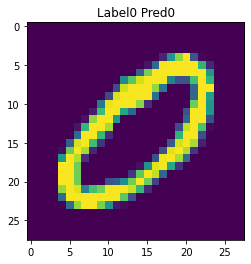

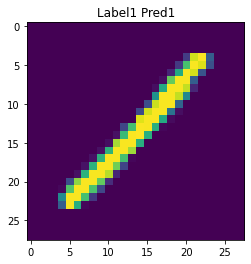

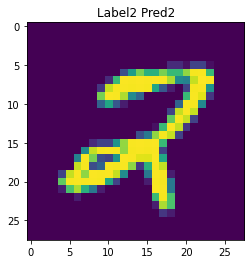

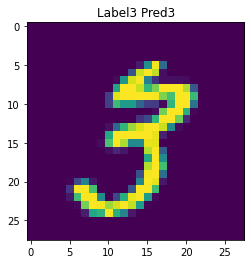

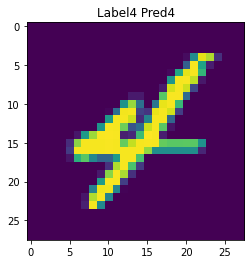

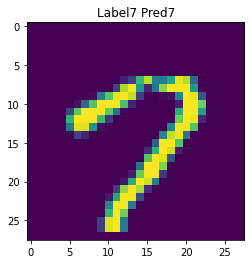

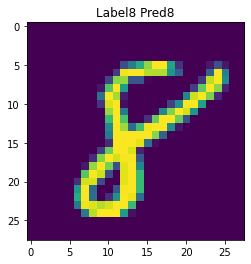

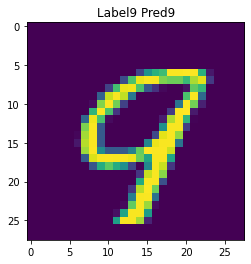

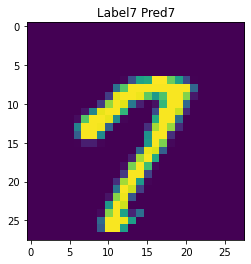

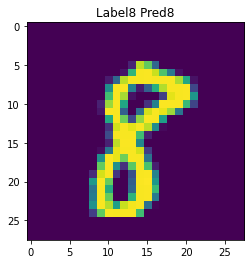

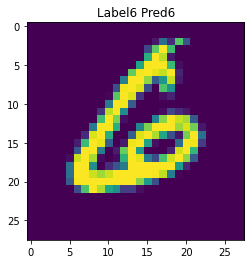

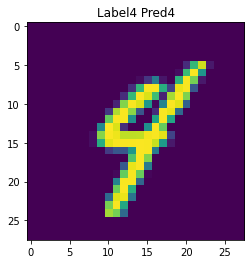

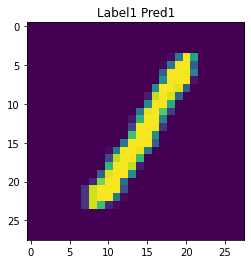

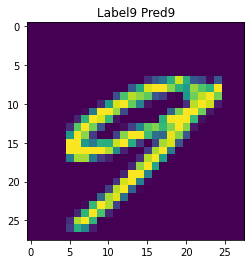

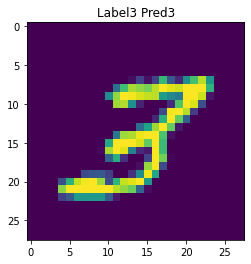

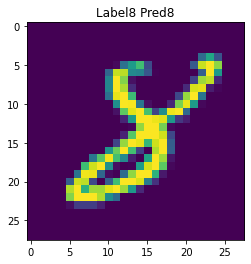

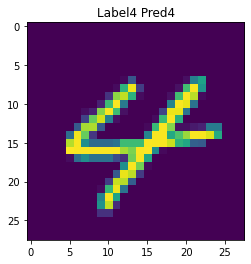

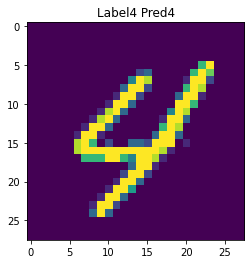

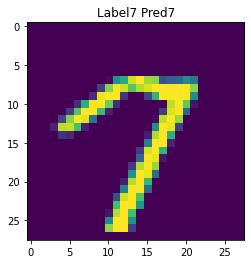

In [17]:
for idx in range(30):
  image = np.array(images[idx,0].detach().cpu()) # 이미지를 보기위해선 numpy로 바꿔주고 CPU연산해줘야한다.
  label = labels[idx].item()
  pred = predicted[idx].item()
  plt.figure()
  plt.title(f'Label{label} Pred{pred}')
  plt.imshow(image*255)